In [81]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [82]:
file = tf.keras.utils
raw_df = pd.read_csv('https://raw.githubusercontent.com/tjsipin/MacDonald-REU-Summer-22/main/models/data/gap_inp_early_2.csv')

In [83]:
#@title Functions to Build and Train a Similarity DNN Model

class SimilarityModel(object):
  """Class to build, train, and inspect a Similarity Model.

  This class builds a deep neural network that maps a dataset of entities
  with heterogenous features to an embedding space.
  Given a dataset as a pandas dataframe, determine the model by specifying
  the set of features used as input and as labels to the DNN, and the
  size of each hidden layer. The data is mapped to the embedding space
  in the last hidden layer.
  
  To build an auto-encoder, make the set of output features identical to the set
  of input features. Alternatively, build a predictor by using a single feature
  as the label. When using a single feature as a label, ensure
  this feature is removed from the input, or add at least
  one hidden layer of a sufficiently low dimension such that the model cannot
  trivially learn the label.
  Caveat: The total loss being minimized is a simple sum of losses for each
    output label (plus the regularization). If the output feature set combines
    sparse and dense features, the total loss is a sum of cross-entropy soft-max
    losses with root mean squared error losses, potentially in different scales,
    which could emphasis some output labels more than others.
  """

  def __init__(self,
               dataframe,
               input_feature_names,
               output_feature_names,
               dense_feature_names,
               sparse_input_feature_embedding_dims,
               hidden_dims=[32],
               l2_regularization=0.0,
               use_bias=True,
               batch_size=100,
               inspect=False):
    """Build a similarity model.

    Args:
      dataframe: the pandas dataframe used to train and validate the model.
      input_feature_names: list of strings, names of input feature columns.
      output_feature_names: list of strings, names of output feature columns.
      dense_feature_names: list of strings, names of feature columns that are
        treated as dense. All other feature columns are treated as sparse.
      sparse_input_feature_embedding_dims: dictionary that maps feature names to
        ints, expressing the embedding dimension of each input feature. Any
        sparse feature in input_feature_names must be in this dictionary.
      hidden_dims: list of ints, dimensions of each hidden layer. These hidden
        layers are not counting the first layer which is a concatenation of the
        input embeddings and the dense input features. Hence, this list can be
        empty, in which case the outputs of the network are directly connected
        to the input embeddings and/or dense inputs.
      use_bias: bool, if true, add a bias term to each hidden layer.
      batch_size: int, batch size.
      inspect: bool, if true, add each tensor of the model to the list of
        tensors that are inspected.
    """
    used_feature_names = tuple(
        set(input_feature_names).union(output_feature_names))
    sparse_feature_names = tuple(
        set(used_feature_names).difference(dense_feature_names))
    # Dictionary mapping each sparse feature column to its vocabulary.
    ### sparse_feature_vocabs = { 'maker': [u'A. Morin', u'AMMA', ...], ... }
    sparse_feature_vocabs = {
        sfn: sorted(list(set(raw_df[sfn].values)))
        for sfn in sparse_feature_names
    }

    # Sparse output features are mapped to ids via tf.feature_to_id, hence
    # we need key-id pairs for these vocabularies.
    sparse_output_feature_names = (
        tuple(set(sparse_feature_names).intersection(output_feature_names)))
    keys_and_values = {}
    for fn in sparse_output_feature_names:
      keys = tf.constant(
          sparse_feature_vocabs[fn],
          dtype=tf.string,
          name='{}_vocab_keys'.format(fn))
      values = tf.range(
          len(sparse_feature_vocabs[fn]),
          dtype=tf.int64,
          name='{}_vocab_values'.format(fn))
      keys_and_values[fn] = (keys, values)

    # Class instance data members.
    self._session = None
    self._loss = None
    self._metrics = {}
    self._embeddings = None
    self._vars_to_inspect = {}

    def split_dataframe(df, holdout_fraction=0.1):
      """Splits a pandas dataframe into training and test sets.

      Args:
        df: the source pandas dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.

      Returns:
        A pair of non-overlapping pandas dataframe for training and holdout.
      """
      test = df.sample(frac=holdout_fraction, replace=False)
      train = df[~df.index.isin(test.index)]
      return train, test

    train_dataframe, test_dataframe = split_dataframe(dataframe)

    def make_batch(dataframe, batch_size):
      """Creates a batch of examples.

      Args:
        dataframe: a panda dataframe with rows being examples and with
          columns being feature columns.
        batch_size: the batch size.

      Returns:
        A dictionary of tensors, keyed by their feature names.
        Each tensor is of shape [batch_size]. Tensors for sparse features are of
        strings, while tensors for dense features are of floats.
      """
      used_features = {ufn: dataframe[ufn] for ufn in used_feature_names}
      batch = (
          tf.data.Dataset.from_tensor_slices(used_features).shuffle(1000)
          .repeat().batch(batch_size).make_one_shot_iterator().get_next())
      if inspect:
        for k, v in six.iteritems(batch):
          self._vars_to_inspect['input_%s' % k] = v
      return batch

    def generate_feature_columns(feature_names):
      """Creates the list of used feature columns.

      Args:
        feature_names: an iterable of strings with the names of the features for
          which feature columns are generated.

      Returns:
        A dictionary, keyed by feature names, of _DenseColumn and
        _NumericColumn.
      """
      used_sparse_feature_names = (
          tuple(set(sparse_feature_names).intersection(feature_names)))
      used_dense_feature_names = (
          tuple(set(dense_feature_names).intersection(feature_names)))
      f_columns = {}
      for sfn in used_sparse_feature_names:
        sf_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=sfn,
            vocabulary_list=sparse_feature_vocabs[sfn],
            num_oov_buckets=0)
        f_columns[sfn] = tf.feature_column.embedding_column(
            categorical_column=sf_column,
            dimension=sparse_input_feature_embedding_dims[sfn],
            combiner='mean',
            initializer=tf.truncated_normal_initializer(stddev=.1))
      for dfn in used_dense_feature_names:
        f_columns[dfn] = tf.feature_column.numeric_column(dfn)
      return f_columns

    def create_tower(features, columns):
      """Creates the tower mapping features to embeddings.

      Args:
        features: a dictionary of tensors of shape [batch_size], keyed by
          feature name. Sparse features are associated to tensors of strings,
          while dense features are associated to tensors of floats.
        columns: a dictionary, keyed by feature names, of _DenseColumn and
          _NumericColumn.

      Returns:
        A pair of elements: hidden_layer and output_layer.
          hidden_layer is a tensor of shape [batch_size, hidden_dims[-1]].
          output_layer is a dictionary keyed by the output feature names, of
            dictionaries {'labels': labels, 'logits': logits}.
            Dense output features have both labels and logits as float tensors 
            of shape [batch_size, 1]. Sparse output features have labels as
            string tensors of shape [batch_size, 1] and logits as float tensors
            of shape [batch_size, len(sparse_feature_vocab)].
      """
      # TODO: sanity check the arguments.
      # Input features.
      input_columns = [columns[fn] for fn in input_feature_names]
      hidden_layer = tf.feature_column.input_layer(features, input_columns)
      dense_input_feature_names = (
          tuple(set(dense_feature_names).intersection(input_feature_names)))
      input_dim = (
          sum(sparse_input_feature_embedding_dims.values()) +
          len(dense_input_feature_names))
      for layer_idx, layer_output_dim in enumerate(hidden_dims):
        w = tf.get_variable(
            'hidden%d_w_' % layer_idx,
            shape=[input_dim, layer_output_dim],
            initializer=tf.truncated_normal_initializer(
                stddev=1.0 / np.sqrt(layer_output_dim)))
        if inspect:
          self._vars_to_inspect['hidden%d_w_' % layer_idx] = w
        hidden_layer = tf.matmul(hidden_layer, w)  # / 10.)
        if inspect:
          self._vars_to_inspect['hidden_layer_%d' % layer_idx] = hidden_layer
        input_dim = layer_output_dim
      # Output features.
      output_layer = {}
      for ofn in output_feature_names:
        if ofn in sparse_feature_names:
          feature_dim = len(sparse_feature_vocabs[ofn])
        else:
          feature_dim = 1
        w = tf.get_variable(
            'output_w_%s' % ofn,
            shape=[input_dim, feature_dim],
            initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                        np.sqrt(feature_dim)))
        if inspect:
          self._vars_to_inspect['output_w_%s' % ofn] = w
        if use_bias:
          bias = tf.get_variable(
              'output_bias_%s' % ofn,
              shape=[1, feature_dim],
              initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                          np.sqrt(feature_dim)))
          if inspect:
            self._vars_to_inspect['output_bias_%s' % ofn] = bias
        else:
          bias = tf.constant(0.0, shape=[1, feature_dim])
        output_layer[ofn] = {
            'labels':
                features[ofn],
            'logits':
                tf.add(tf.matmul(hidden_layer, w), bias)  # w / 10.), bias)
        }
        if inspect:
          self._vars_to_inspect['output_labels_%s' %
                                ofn] = output_layer[ofn]['labels']
          self._vars_to_inspect['output_logits_%s' %
                                ofn] = output_layer[ofn]['logits']
      return hidden_layer, output_layer

    def similarity_loss(top_embeddings, output_layer):
      """Build the loss to be optimized.

      Args:
        top_embeddings: First element returned by create_tower.
        output_layer: Second element returned by create_tower.

      Returns:
        total_loss: A tensor of shape [1] with the total loss to be optimized.
        losses: A dictionary keyed by output feature names, of tensors of shape
          [1] with the contribution to the loss of each output feature.
      """
      losses = {}
      total_loss = tf.scalar_mul(l2_regularization,
                                 tf.nn.l2_loss(top_embeddings))
      for fn, output in six.iteritems(output_layer):
        if fn in sparse_feature_names:
          losses[fn] = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=output['logits'],
                  labels=tf.feature_to_id(
                      output['labels'], keys_and_values=keys_and_values[fn])))
        else:
          losses[fn] = tf.sqrt(
              tf.reduce_mean(
                  tf.square(output['logits'] -
                            tf.cast(output['labels'], tf.float32))))
        total_loss += losses[fn]
      return total_loss, losses

    # Body of the constructor.
    input_feature_columns = generate_feature_columns(input_feature_names)
    # Train
    with tf.variable_scope('model', reuse=False):
      train_hidden_layer, train_output_layer = create_tower(
          make_batch(train_dataframe, batch_size), input_feature_columns)
      self._train_loss, train_losses = similarity_loss(train_hidden_layer,
                                                       train_output_layer)
    # Test
    with tf.variable_scope('model', reuse=True):
      test_hidden_layer, test_output_layer = create_tower(
          make_batch(test_dataframe, batch_size), input_feature_columns)
      test_loss, test_losses = similarity_loss(test_hidden_layer,
                                               test_output_layer)
    # Whole dataframe to get final embeddings
    with tf.variable_scope('model', reuse=True):
      self._hidden_layer, _ = create_tower(
          make_batch(dataframe, dataframe.shape[0]), input_feature_columns)
    # Metrics is a dictionary of dictionaries of dictionaries.
    # The 3 levels are used as plots, line colors, and line styles respectively.
    self._metrics = {
        'total': {
            'train': {'loss': self._train_loss},
            'test': {'loss': test_loss}
        },
        'feature': {
            'train': {'%s loss' % k: v for k, v in six.iteritems(train_losses)},
            'test': {'%s loss' % k: v for k, v in six.iteritems(test_losses)}
        }
    }

  def train(self,
            num_iterations=30,
            learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.

    Args:
      num_iterations: int, the number of iterations to run.
      learning_rate: float, the optimizer learning rate.
      plot_results: bool, whether to plot the results at the end of training.
      optimizer: tf.train.Optimizer, the optimizer to be used for training.
    """
    with self._train_loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._train_loss)
      opt_init_op = tf.variables_initializer(opt.variables())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.local_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      self._session.run(opt_init_op)
      if plot_results:  
        iterations = []
        metrics_vals = {k0: {k1: {k2: []
                                  for k2 in v1}
                             for k1, v1 in six.iteritems(v0)}
                        for k0, v0 in six.iteritems(self._metrics)}

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, self._metrics))

        # Printing the 1 liner with losses.
        if (i % 10 == 0) or i == num_iterations:
          print('\riteration%6d,   ' % i + ',   '.join(
              ['%s %s %s: %7.3f' % (k0, k1, k2, v2)
               for k0, v0 in six.iteritems(results)
               for k1, v1 in six.iteritems(v0)
               for k2, v2 in six.iteritems(v1)])
                , end=" "
               )
          if plot_results:
            iterations.append(i)
            for k0, v0 in six.iteritems(results):
              for k1, v1 in six.iteritems(v0):
                for k2, v2 in six.iteritems(v1):
                  metrics_vals[k0][k1][k2].append(results[k0][k1][k2])

      # Feedforward the entire dataframe to get all the embeddings.
      self._embeddings = self._session.run(self._hidden_layer)

      # Plot the losses and embeddings.
      if plot_results:
        num_subplots = len(metrics_vals) + 1
        colors = 10 * ('red', 'blue', 'black', 'green')
        styles = 10 * ('-', '--', '-.', ':')
        # Plot the metrics.
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i0, (k0, v0) in enumerate(six.iteritems(metrics_vals)):
          ax = fig.add_subplot(1, num_subplots, i0+1)
          ax.set_title(k0)
          for i1, (k1, v1) in enumerate(six.iteritems(v0)):
            for i2, (k2, v2) in enumerate(six.iteritems(v1)):
              ax.plot(iterations, v2, label='%s %s' % (k1, k2),
                      color=colors[i1], linestyle=styles[i2])
          ax.set_xlim([1, num_iterations])
          ax.set_yscale('log')
          ax.legend()
        # Plot the embeddings (first 3 dimensions).
        ax.legend(loc='upper right')
        ax = fig.add_subplot(1, num_subplots, num_subplots)
        ax.scatter(
            self._embeddings[:, 0], self._embeddings[:, 1],
            alpha=0.5, marker='o')
        ax.set_title('embeddings')


  @property
  def embeddings(self):
    return self._embeddings

In [84]:
raw_df.columns

Index(['Year', 'Country', 'Population', 'Cutaneous.Leishmaniasis', 'Dengue',
       'Malaria', 'Mucosal.Leishmaniasis', 'Visceral.Leishmaniasis',
       'Yellow.Fever', 'LST_Day', 'LST_Night', 'OptTemp_Obs',
       'Dengue_Alb_OptTemp', 'Dengue_Aeg_OptTemp', 'Chik_Alb_OptTemp',
       'Chik_Aeg_OptTemp', 'Zika_OptTemp', 'Malaria_OptTemp', 'NDVI', 'EVI',
       'Precip', 'StableLights', 'SWOccurrence'],
      dtype='object')

------ build model
------ train model


2022-07-18 16:12:32.688218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 16:12:32.689023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-07-18 16:12:32.957433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 16:12:33.073258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 16:12:33.095338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 16:12:33.105260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 16:12:33.118260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


iteration  1000,   total train loss: 3745591.500,   total test loss: 8731981.000,   feature train Cutaneous.Leishmaniasis loss:  10.427,   feature test Cutaneous.Leishmaniasis loss:  14.766   9 07.296 0.367 

2022-07-18 16:12:42.814030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


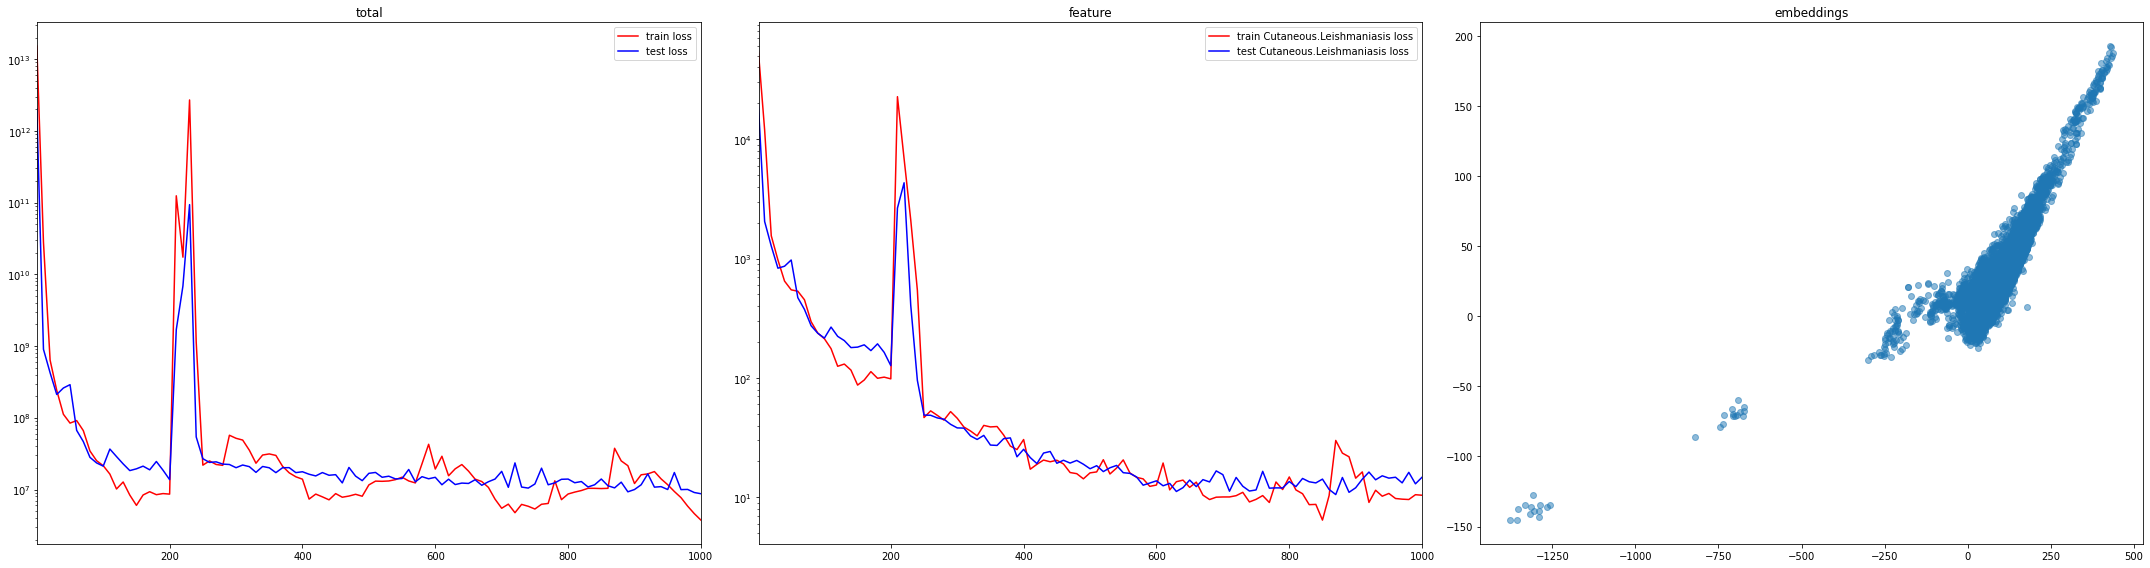

In [85]:
#@title Training a DNN Similarity Model

# Define some constants related to this dataset.
sparse_feature_names = ('Country')
dense_feature_names =   ('Population', 'Cutaneous.Leishmaniasis',
                        'Yellow.Fever', 'LST_Day', 'LST_Night', 'NDVI', 'EVI',
                        'Precip', 'StableLights', 'SWOccurrence')

# Set of features used as input to the similarity model.
input_feature_names = ('Population', 'LST_Day', 'LST_Night', 'NDVI', 'EVI', 'Precip', 'StableLights', 'SWOccurrence', 'Cutaneous.Leishmaniasis',)
# Set of features used as output to the similarity model.
output_feature_names =   ['Cutaneous.Leishmaniasis']#@param

# As a rule of thumb, a reasonable choice for the embedding dimension of a
# sparse feature column is the log2 of the cardinality of its vocabulary.
# sparse_input_feature_embedding_dims = { 'maker': 9, 'maker_location': 6, ... }
default_embedding_dims = {
    sfn: int(round(math.log(raw_df[sfn].nunique()) / math.log(2)))
    for sfn in set(sparse_feature_names).intersection(input_feature_names)
}
# Dictionary mapping each sparse input feature to the dimension of its embedding
# space.
sparse_input_feature_embedding_dims = default_embedding_dims  # can be a param

# Weight of the L2 regularization applied to the top embedding layer.
l2_regularization =   10#@param
# List of dimensions of the hidden layers of the deep neural network.
hidden_dims = [10, 6, 3]  #@param

print('------ build model')
with tf.Graph().as_default():
  similarity_model = SimilarityModel(
      raw_df,
      input_feature_names=input_feature_names,
      output_feature_names=output_feature_names,
      dense_feature_names=dense_feature_names,
      sparse_input_feature_embedding_dims=sparse_input_feature_embedding_dims,
      hidden_dims=hidden_dims,
      l2_regularization=l2_regularization,
      batch_size=100,
      use_bias=True,
      inspect=True)

print('------ train model')
similarity_model.train(
    num_iterations=1000,
    learning_rate=0.1,
    optimizer=tf.train.AdagradOptimizer)
print('\n')


In [86]:
#@title Run cell to set up functions
def dfSimilarity(df,centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df,axis=1))
  pointNorms = np.reshape(pointNorms,[numPoints,1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids,axis=1))
  centroidNorms = np.reshape(centroidNorms,(1,numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0*np.dot(df,np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities/10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df,k,feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0,limit-1,k)
  centroids = df.loc[centroids_key,feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True,inplace=True)
  return centroids

def pt2centroid(df,centroids,feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:,feature_cols],centroids.loc[:,feature_cols])
  df.loc[:,'centroid'] = np.argmin(dist,axis=1) # closest centroid
  df.loc[:,'pt2centroid'] = np.min(dist,axis=1) # minimum distance
  return df

def recomputeCentroids(df,centroids,feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen, feature_cols] # all points for centroid
    if not(dfSubset.empty): # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset)/len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df,k,feature_cols,verbose):
  flagConvergence = False
  maxIter = 200
  iter = 0                      # ensure kmeans doesn't run for ever
  centroids = initCentroids(df,k,feature_cols)
  while not(flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df,centroids,feature_cols)
    centroids = recomputeCentroids(df,centroids,feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print("Total distance:" + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df,centroids]

In [87]:
k = 19

choc_embed = similarity_model.embeddings
choc_embed = pd.DataFrame(choc_embed)
choc_embed
feature_cols = choc_embed.columns.values
feature_cols
choc_embed['centroid'] = k
choc_embed
choc_embed['pt2centroid'] = 2
choc_embed
[choc_embed,centroids] = kmeans(choc_embed,k,feature_cols,0)
choc_embed['pt2centroid'].describe()


k-means converged for 19 clusters after 94 iterations!


count    31887.000000
mean         3.323889
std          4.908563
min          0.034233
25%          1.953912
50%          2.792428
75%          3.809169
max        190.808411
Name: pt2centroid, dtype: float64

In [88]:
choc_embed['pt2centroid'].describe()

count    31887.000000
mean         3.323889
std          4.908563
min          0.034233
25%          1.953912
50%          2.792428
75%          3.809169
max        190.808411
Name: pt2centroid, dtype: float64

In [94]:
raw_df.reset_index()

,index,Year,Country,Population,Cutaneous.Leishmaniasis,Dengue,Malaria,Mucosal.Leishmaniasis,Visceral.Leishmaniasis,Yellow.Fever,...,Dengue_Aeg_OptTemp,Chik_Alb_OptTemp,Chik_Aeg_OptTemp,Zika_OptTemp,Malaria_OptTemp,NDVI,EVI,Precip,StableLights,SWOccurrence
0,0,2007,Colombia,1801730,0.000555,0.002775,0.002220,0.000000,0.000000,0.0,...,0,14,0,0,22,0.500981,0.304495,2087.610085,37.972903,17.033807
1,1,2008,Colombia,1839334,0.005980,0.493657,0.010874,0.000000,0.000000,0.0,...,0,8,0,0,9,0.475580,0.287916,2553.313095,20.001042,17.033807
2,2,2009,Colombia,1894391,0.001584,0.218012,0.009502,0.000000,0.000000,0.0,...,1,9,1,1,16,0.527427,0.329218,1812.452090,38.951077,17.033807
3,3,2010,Colombia,1937458,0.003097,8.036303,0.018065,0.000000,0.000000,0.0,...,2,19,2,2,22,0.499809,0.312449,2402.545373,45.657085,17.033807
4,4,2011,Colombia,1960132,0.003061,0.409156,0.005102,0.000510,0.000000,0.0,...,0,13,0,0,18,0.492869,0.322488,2430.899353,40.699944,17.033807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31882,31882,2009,Brazil,2183588,0.016029,0.377361,0.000916,0.005168,0.005496,0.0,...,12,18,12,12,11,0.546935,0.324644,1561.835589,17.770364,82.170640
31883,31883,2010,Brazil,2232600,0.030458,6.741467,0.000448,0.003838,0.003135,0.0,...,13,12,13,13,3,0.500407,0.301671,1198.567429,23.007724,82.170640
31884,31884,2011,Brazil,2283341,0.019270,0.621896,0.000000,0.005174,0.005255,0.0,...,17,15,17,17,6,0.508265,0.308481,1387.993727,21.254124,82.170640
31885,31885,2012,Brazil,2334984,0.016702,0.632981,0.000428,0.005479,0.005139,0.0,...,13,14,13,13,8,0.514200,0.304497,1238.283174,23.606964,82.170640


In [95]:
choc_indexed = choc_embed.reset_index()
raw_indexed = raw_df.reset_index()
choc_indexed

,index,0,1,2,centroid,pt2centroid
0,0,130.281570,53.223465,-152.412643,13,5.689491
1,1,95.257607,37.737926,-123.666122,7,6.054311
2,2,180.779724,67.220398,-208.650696,18,6.725186
3,3,136.854309,31.740149,-123.020554,15,4.541992
4,4,205.989136,84.127007,-243.546982,18,8.176662
...,...,...,...,...,...,...
31882,31882,83.352768,16.580612,-87.751968,2,1.948206
31883,31883,66.944931,15.915638,-77.795044,17,0.716027
31884,31884,91.720657,23.978136,-99.548843,10,1.875000
31885,31885,62.804455,11.214412,-69.322182,17,2.836220


In [99]:
cluster_merged = pd.merge(raw_indexed, choc_indexed, on = 'index').drop(['index'], axis = 1)
pd.DataFrame.to_csv(cluster_merged, path_or_buf='cluster.csv')

In [ ]:
cluster = pd.DataFrame()
for x in range(k):
    y = raw_df.loc[choc_embed['centroid'] == x,:].median()
    cluster = cluster.append(y, ignore_index=True)
cluster

/var/folders/nj/v28m9jyd30jc52dz2z8b2hrr0000gn/T/ipykernel_29017/918756329.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y = raw_df.loc[choc_embed['centroid'] == x,:].median()
/var/folders/nj/v28m9jyd30jc52dz2z8b2hrr0000gn/T/ipykernel_29017/918756329.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster = cluster.append(y, ignore_index=True)
/var/folders/nj/v28m9jyd30jc52dz2z8b2hrr0000gn/T/ipykernel_29017/918756329.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y = raw_df.loc[choc_embed['centroid'] == x,:].median()
/var/folders/nj/v28m9jyd30jc52dz2

,Year,Population,Cutaneous.Leishmaniasis,Dengue,Malaria,Mucosal.Leishmaniasis,Visceral.Leishmaniasis,Yellow.Fever,LST_Day,LST_Night,...,Dengue_Aeg_OptTemp,Chik_Alb_OptTemp,Chik_Aeg_OptTemp,Zika_OptTemp,Malaria_OptTemp,NDVI,EVI,Precip,StableLights,SWOccurrence
0,2011.0,13616.5,0.474865,0.249109,0.013687,0.000000,0.0,0.0,25.886236,15.574684,...,4.0,10.0,4.0,4.0,9.0,0.607854,0.412407,1934.930814,0.632283,27.311707
1,2007.0,16368.0,0.171705,0.332930,0.000000,0.008130,0.0,0.0,29.236691,19.127659,...,7.0,11.0,7.0,7.0,9.0,0.607699,0.392275,1337.488721,2.190392,29.959195
2,2008.0,15482.0,0.201045,0.411565,0.000000,0.007609,0.0,0.0,28.847646,18.945106,...,7.0,11.0,7.0,7.0,10.0,0.596338,0.384489,1188.231903,1.196003,25.732132
3,2008.0,12691.5,0.521686,0.356621,0.000000,0.013790,0.0,0.0,29.177619,20.704439,...,10.0,10.0,10.0,10.0,7.0,0.632427,0.416345,1683.508152,0.276916,33.339214
4,2008.0,21472.0,0.142980,0.394011,0.000000,0.005922,0.0,0.0,28.404426,17.148133,...,8.0,9.0,8.0,8.0,9.0,0.603947,0.381714,1302.546119,3.803658,37.992144
5,2011.0,11064.0,0.403448,0.265260,0.000000,0.000000,0.0,0.0,26.269938,15.523111,...,4.0,11.0,4.0,4.0,9.0,0.598997,0.406426,1923.079584,0.437726,32.837467
6,2007.0,14831.0,0.200995,0.334364,0.000000,0.008746,0.0,0.0,29.075298,18.438051,...,8.0,11.0,8.0,8.0,9.0,0.606839,0.387902,1289.228779,1.060409,27.339282
7,2009.0,14952.0,0.541670,0.317916,0.227740,0.011006,0.0,0.0,27.494044,20.796899,...,10.0,15.0,10.0,10.0,11.0,0.648766,0.438098,2070.026385,0.227184,36.568320
8,2007.0,13225.0,0.258264,0.310270,0.000000,0.009557,0.0,0.0,29.463328,18.794624,...,8.0,9.0,8.0,8.0,7.0,0.611774,0.389589,1425.433533,0.696026,30.692099
9,2008.0,16407.0,0.172376,0.957354,0.000000,0.009019,0.0,0.0,29.118620,18.652089,...,8.0,9.0,8.0,8.0,7.0,0.590529,0.379005,1268.823089,1.169475,30.634441


In [ ]:
pd.DataFrame.to_csv(cluster, path_or_buf='cluster.csv')

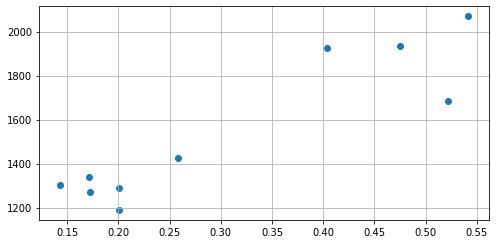

In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.grid()
plt.scatter(cluster['Cutaneous.Leishmaniasis'], cluster['Precip'], marker = 'o')

In [ ]:
k =  160#@param

# Extract embeddings into a dataframe
choc_embed = similarity_model.embeddings
choc_embed = pd.DataFrame(raw_df)

feature_cols = choc_embed.columns.values # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_embed['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_embed['pt2centroid'] = 2
[choc_embed, centroids] = kmeans(choc_embed,k,feature_cols,1)
# print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:")
choc_embed.head()

TypeError: loop of ufunc does not support argument 31887 of type str which has no callable conjugate method

In [ ]:
cluster = pd.DataFrame()
for x in range(k):
    y = raw_df.loc[choc_embed['centroid'] == x,:].mean()
    cluster = cluster.append(y, ignore_index=True)
cluster